# Frozen Lake: Markov Decision Process

In reinforcement learning, an agent is acting in an environment, and learning by trial-and-error to optimize its performance in order to gain maximal cumulative reward. The model of the environment can be formalized by a Markov Decision Process (MDP). If the MDP is given, there is no need of a learning agent, and the problem of finding an optimal policy can be solved applying dynamic programming (DP). This is called planning. As the MDP for the Frozen Lake game is known, the optimal policy can be found using these methods. In this notebook Frozen Lake's MDP is discussed, along with the dynamic programming methods to solve it. The solutions can be used later to verify the agent's learning algorithms.

## Import module ReinforcementLearning

To solve MDPs, a class "MarkovDecisionProcess" is developed, which is also part of the "ReinforcementLearning" module. Importing this module also imports packages "numpy" as "np" and "matplotlib.pyplot" as "plt". Matplotlib is set to the interactive "notebook" mode:

In [1]:
from ReinforcementLearning import *
%matplotlib notebook

## Frozen Lake's MDP 

A Markov Decision Process is fully defined if the states, the actions, the probabilities and the rewards are known. In the Frozen Lake game, there are 16 states which correspond to the grid cells, and 4 possible moves which are the actions. The probability to reach a certain state from a given state taking a certain action and the reward received after taking this action, is also known and can be found in the original "FrozenLake-v0" object. By definition, an MDP is stochastic, but it is possible to create a deterministic FrozenLake environment, which is easier to understand. 

### Deterministic case

#### Defining the MDP 

A deterministic "FrozenLake" environment is created first:

In [2]:
env = FrozenLake.make(is_slippery=False)

The probability to reach a certain state from a given state taking a certain action and the rewards received after taking this action, is found in attribute "P" of the original "FrozenLake-v0" object, which is stored in attribute "gym_env" of the created "FrozenLake" object. For instance, if action 2 (= moving east) is taken in grid cell 9, then the probabilities of getting in the adjacent cells are:

In [3]:
state = 9
action = 2
env.gym_env.P[state][action]

[(1.0, 10, 0.0, False)]

Since the environment is not slippery, moving to the right from cell 9 effectively moves the cursor to cell number 10, indicated by the second element in the returned tuple. This means that the probability of getting in cell 10 from cell 9 when moving to the right is 1.0 or 100%, which is indicated by the first element in the output. The third element in the output is the reward, which is zero. The last element is "False", meaning that cell 10 is not a terminal state and the game is not finished yet.   

This "P" attribute can now be used to construct a state transition matrix "Psas" and a reward matrix "Rsas". Both are 3D matrices with 16 x 4 x 16 elements, where the first dimension refers to the states s, the second dimension to the actions a, and the third dimension to the next states s'. In the case of "Psas", the elements are the probabilities to get in state s' from state s when action a is taken, in the case of "Rsas", these elements are the corresponding rewards. Transforming attribute "P" to matrices Psas and Rsas can be done using three loops: 

In [4]:
nstates = env.nstates
nactions = env.nactions

states = range(nstates)
actions = range(nactions)

Psas = np.zeros((nstates, nactions, nstates))
Rsas = np.zeros((nstates, nactions, nstates))

P = env.gym_env.P
for s in states:
    for a in actions:
        for n in range(len(P[s][a])):
            probability = P[s][a][n][0]
            next_state = P[s][a][n][1]
            reward = P[s][a][n][2]
            Psas[s, a, next_state] = probability
            Rsas[s, a, next_state] = reward

All necessary variables are available now to create a MarkovDecisionProcess object for the FrozenLake environment:

In [5]:
mdp = MarkovDecisionProcess(states, actions, Psas, Rsas)

States, actions, and matrices "Psas" and "Rsas" are stored in attirbutes with the same name. The number of states and actions are found in attributes "nstates" and "nactions" respectively. Checking if the probability is 1.0 to get in cell 10, and the reward is 0.0, when going to the right in cell 9: 

In [6]:
state = 9
action = 2
print(mdp.Psas[state, action, :])
print(mdp.Rsas[state, action, :])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


All the elements in the first printed array are zero, except the 11th, which is 1.0, the probability of getting in cell 10. All elements in the second printed array are zero, also the 11th element, as the reward is 0.0.

The probabilities and rewards given by attribute "P" are transformed into two separate matrices because the latter are easier to manipulate algebraically. These manipulations are required to solve the MDP. To make this transformation easier, a subclass "GymMDP" of class "MarkovDecisionProcess" is available that automatically creates the required matrices from a given OpenAI Gym environment:

In [7]:
mdp = GymMDP(env)
print(mdp.Psas[state, action, :])
print(mdp.Rsas[state, action, :])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


The "GymMDP" class also sets probabilities in terminal states equal to zero. This avoids that the MDP matrix system is singular and cannot be solved. In the original MDP, this is not the case, as Psas[s, a, s] is 1.0, when s is a terminal state. As a consequence, the original MDP is not defined as episodic, because choosing actions in terminal states can go on forever. The "GymMDP" class makes the MDP episodic by setting all probabilities in terminal states equal to zero. Selecting the probabilities in state 15, for instance, returns an array of zeros indeed:

In [8]:
print(mdp.Psas[15, :, 15])

[0. 0. 0. 0.]


#### Policy Evaluation 

The purpose of reinforcement learning is to gain maximum total reward. The total reward, also called return, is defined as the sum of all rewards received during an episode. Therefore it is not always benificial to choose an action that leads to maximum immediate reward. Instead, it is more interesting to choose an action that has the maximum expected return. The state-value funcion V(s) gives the expected return for state s, whereas the action-value function Q(s,a) gives the expected return for state s when action a is chosen. 

When the MDP is known, the value functions corresponding to a given policy can be calculated by solving the system of Bellman expectation equations. This is called policy evaluation. The "MarkovDecisionProcess" class has a method "policy_evaluation" to evaluate a given policy. Suppose a deterministic policy is defined to go as fast as possible to the final state: 

In [9]:
P = np.zeros((env.nstates, env.nactions))
P[0, 1] = 1  # 0 -> down -> 4
P[4, 1] = 1  # 4 -> down -> 8
P[8, 2] = 1  # 8 -> right -> 9
P[9, 2] = 1  # 9 -> right -> 10
P[10, 1] = 1  # 10 -> down -> 14
P[14, 2] = 1  # 14 -> right -> 15
policy = Policy(P, env)

If the policy is passed to method "policy_evaluation", the state-value function Vs and action-value function Qsa is returned:

In [10]:
Vs, Qsa = mdp.policy_evaluation(policy)
print("state-values:")
print(np.reshape(Vs, (4, 4), order="C"))
print("action-values:")
print(Qsa)

state-values:
[[1. 0. 0. 0.]
 [1. 0. 0. 0.]
 [1. 1. 1. 0.]
 [0. 0. 1. 0.]]
action-values:
[[1. 1. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 1.]
 [0. 1. 1. 1.]
 [0. 0. 0. 0.]]


The state-values Vs can be plotted using the "plot" method of class "FrozenLake":

<IPython.core.display.Javascript object>


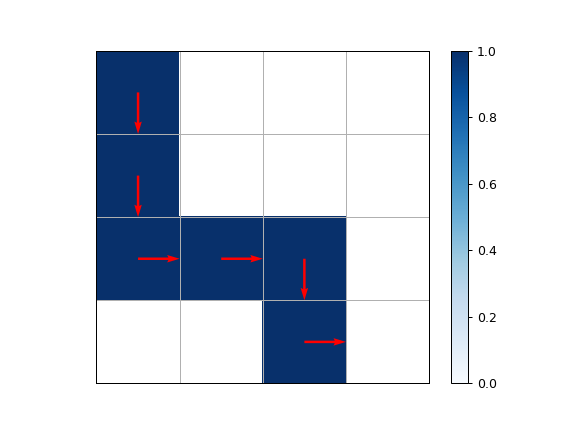

In [11]:
env.plot(policy=policy, values=Vs)

The result is not surprising: each cell that is part of the given policy has a state-value Vs of 1.0 as the excepted return is 1.0 indeed when te final state is reached. Cells that are not included have a state-value Vs of 0.0. Terminal states always have a state-value Vs of 0.0. The action-value Qsa is 1.0 if the action leads to a cell that is part of the policy, and 0.0 otherwise.

Next the uniform random policy is evaluated. This is a stochastic policy, so the values will be less than 1 because the final state is not always reached:

In [12]:
policy = UniformRandomPolicy(env)
Vs, Qsa = mdp.policy_evaluation(policy)
print("state-values:")
print(np.reshape(Vs, (4, 4), order="c"))
print("action-values:")
print(Qsa)

state-values:
[[0.0139398  0.01163093 0.02095299 0.01047649]
 [0.01624867 0.         0.04075154 0.        ]
 [0.0348062  0.08816993 0.14205316 0.        ]
 [0.         0.17582037 0.43929118 0.        ]]
action-values:
[[0.0139398  0.01624867 0.01163093 0.0139398 ]
 [0.0139398  0.         0.02095299 0.01163093]
 [0.01163093 0.04075154 0.01047649 0.02095299]
 [0.02095299 0.         0.01047649 0.01047649]
 [0.01624867 0.0348062  0.         0.0139398 ]
 [0.         0.         0.         0.        ]
 [0.         0.14205316 0.         0.02095299]
 [0.         0.         0.         0.        ]
 [0.0348062  0.         0.08816993 0.01624867]
 [0.0348062  0.17582037 0.14205316 0.        ]
 [0.08816993 0.43929118 0.         0.04075154]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.17582037 0.43929118 0.08816993]
 [0.17582037 0.43929118 1.         0.14205316]
 [0.         0.         0.         0.        ]]


The value-functions are calculated applying the recursive Bellman expectation equation. As an illustration, this is done manually for state 14:

In [13]:
Ppolicy = 0.25
Paction = 1.0
R = 1.0

Qwest = Paction * Vs[13].item()
Qsouth = Paction * Vs[14].item()
Qeast = Paction * R
Qnorth = Paction * Vs[10].item()

print("Values for state 14:")
print("Qwest is " + str(Qwest))
print("Qsouth is " + str(Qsouth))
print("Qeast is " + str(Qeast))
print("Qnorth is " + str(Qnorth))
print("V is " + str(Ppolicy * (Qnorth + Qsouth + Qwest + Qeast)))

Values for state 14:
Qwest is 0.1758203699962481
Qsouth is 0.43929117723455224
Qeast is 1.0
Qnorth is 0.1420531617074086
V is 0.43929117723455224


Finally, the policy and corresponding state-values are plotted:

<IPython.core.display.Javascript object>


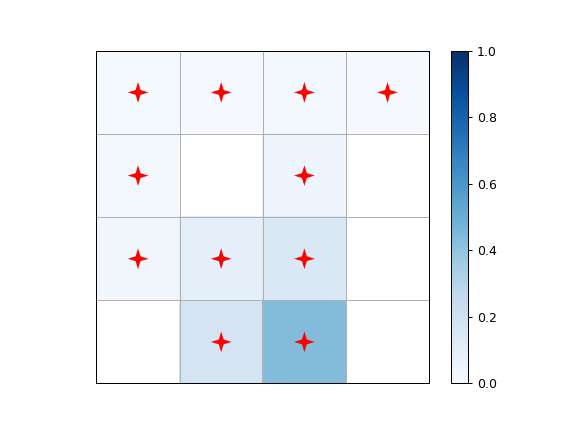

In [14]:
env.plot(policy=policy, values=Vs)

#### Policy improvement 

The policy can be updated now to a policy in which the actions with the largest action-value are chosen. This can also be seen as selecting the actions that lead to one of the states with the largest state-value. This selection of actions is called policy improvement. Class "MarkovDecisionProcess" provides a method "policy_improvement" that returns the improved policy for a given state-value function V.

In [15]:
policy = mdp.policy_improvement(Vs)
Vs, Qsa = mdp.policy_evaluation(policy)
print(np.reshape(Vs, (4, 4), order="C"))
print(Qsa)

[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


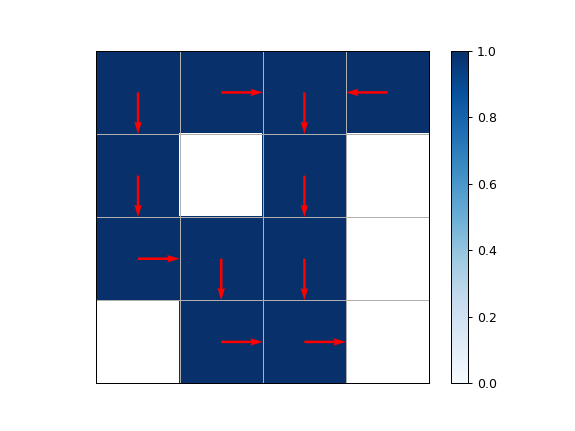

In [16]:
env.plot(policy=policy, values=Vs)

This result makes sense as it gives the shortest path from a given cell to the final cell. However, in certain cells different actions can be chosen, as long as the holes are avoided. In the starting position, for instance, all actions are possible, because each of them can lead to winning the game with a final reward of 1, even if some actions are not following the shortest path. After all, the game is not about finding the shortest path, the only goal is to reach cell 15 without falling into a hole. Improving the policy again based on the new state-value function indeed gives us all possible actions:    

In [17]:
policy = mdp.policy_improvement(Vs)
Vs, Qsa = mdp.policy_evaluation(policy)
print(np.reshape(Vs, (4, 4), order="C"))
print(Qsa)

[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


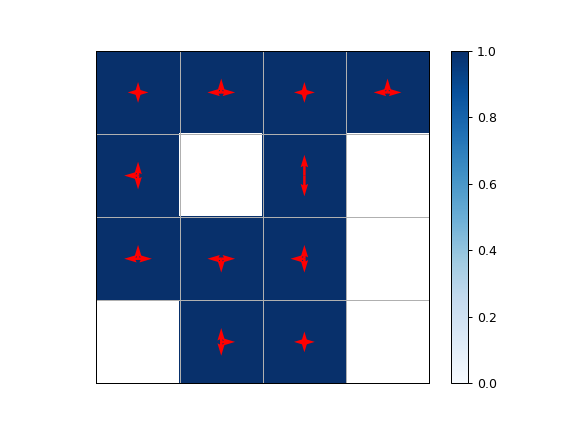

In [18]:
env.plot(policy=policy, values=Vs)

#### Policy Iteration

Iteratively evaluating and improving policies is an effective way to find the optimal solution. This procedure is called policy iteration and the algorithm is implemented in method "policy_iteration" in class "MarkovDecisionProcess". So the successive steps in the above example can be done in one method call: 

[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


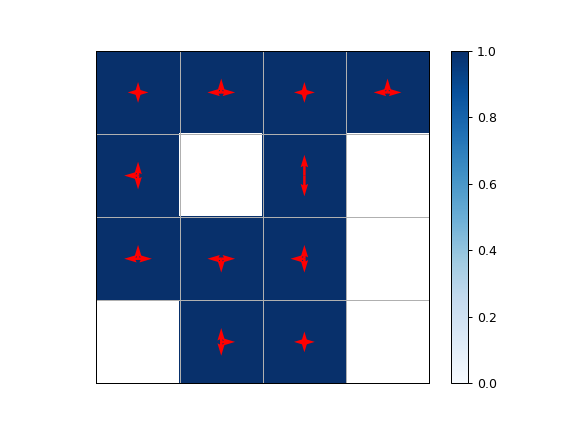

In [19]:
policy, Vs, Qsa = mdp.policy_iteration(outer=2)
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(policy=policy, values=Vs)

Method "policy_iteration" successively calls methods "policy_evaluation" and "policy_improvement" a number of times. This number of times is determined by optional argument "outer", which is 100 by default. Because it was shown earlier that two iterations are sufficient, "outer" was set to 2. These successive policy evaluation and improvement steps are the outer iterations performed by the policy iteration algorithm.

The inner iterations are executed in the policy evaluation step. Therefore, methods "policy_evaluation" and "policy_iteration" also accept an optional argument "inner" indicating the number of inner iterations. By default, this number is equal to 0, which means the system of Bellman expectation equations is solved algebraically applying a direct solver. If "inner" is set to an integer number larger than zero, an iterative dynamic programming algorithm is applied with the number of inner iterations equal to "inner":  

In [20]:
Vs, Qsa = mdp.policy_evaluation(policy, inner=2000)
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)

[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


It is clear that this small problem is solved more efficiently applying the direct solver. The iterative procedure, however, is more efficient or even the only option in case of very large problems. 

Note that the default values for the optional arguments "inner" and "outer" are modified by setting the attributes with the same name:

In [21]:
print("default number of inner iterations: " + str(mdp.inner))
print("default number of outer iterations: " + str(mdp.outer))

default number of inner iterations: 0
default number of outer iterations: 100


#### Value Iteration 

A more effective dynamic programming method to find the optimal policy is value iteration. It solves iteratively the system of Bellman optimality equations. Intuitively, it can be seen as if it combines policy evaluation and improvement in one step by reducing the number of inner iterations to 1. By doing this, it doesn't have to determine the policy explicitely during each outer iteration. This makes it more efficient than policy evaluation. Class "MarkovDecisionProces" provides a method "value_iteration": 

[[1. 1. 1. 1.]
 [1. 0. 1. 0.]
 [1. 1. 1. 0.]
 [0. 1. 1. 0.]]
[[1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 1. 1.]
 [1. 0. 1. 1.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 1. 0. 1.]
 [0. 0. 0. 0.]
 [1. 0. 1. 1.]
 [1. 1. 1. 0.]
 [1. 1. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


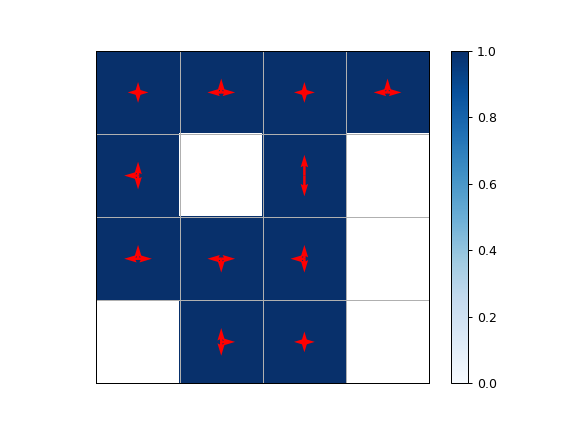

In [22]:
policy, Vs, Qsa = mdp.value_iteration(outer=10)
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa) 
env.plot(policy=policy, values=Vs)

Because value iteration reduces the number of inner iterations to 1 automatically, it needs more than 2 outer iterations to converge to the optimal solution. In this case, 10 is sufficient.

#### Shortest path 

Suppose the goal of the game is to get in the last cell as soon as possible, then each step should be punished with a negative reward of -1. This can be simulated easily. First the zeros in the Rsas matrix must be replaced by -1:

In [23]:
mdp.Rsas[mdp.Rsas < 1] = -1

Applying value iteration gives the solution:

<IPython.core.display.Javascript object>


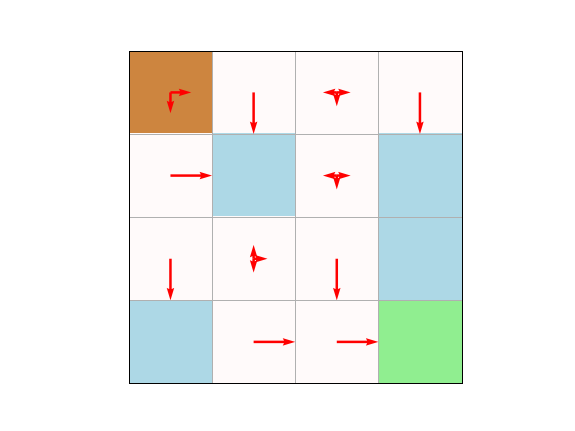

In [24]:
policy, Vs, Qsa = mdp.value_iteration(outer=100)
env.plot(policy=policy)

But that is not exactly the expected solution. The problem is that the reward of reaching the last cell is too small compared to the negative reward of -1 given after each step. As a consequence, it is in most cases more interesting to fall into a hole than to reach the final state with reward 1. To fix this, the final reward is set to 6, which is the minimal number of steps required to get in state 15 starting from state 0.

[[1. 2. 3. 2.]
 [2. 0. 4. 0.]
 [3. 4. 5. 0.]
 [0. 5. 6. 0.]]


<IPython.core.display.Javascript object>


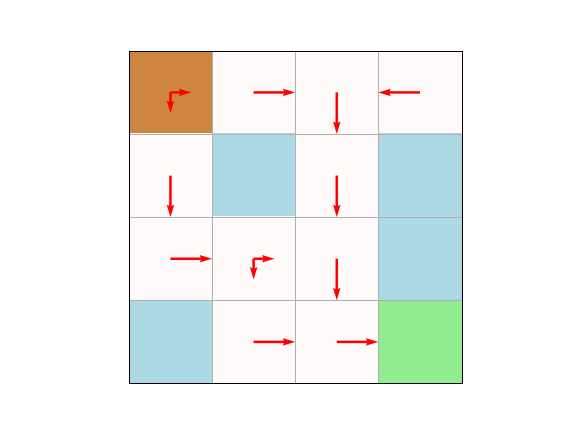

In [25]:
mdp.Rsas[mdp.Rsas > 0] = 6

policy, Vs, Qsa = mdp.value_iteration()
print(np.reshape(Vs, (4, 4), order="c"))
env.plot(policy=policy)

Now the shortest path to state 15 is shown for each state, as was requested. A more efficient way to find this shortest path policy is discussed later in this notebook.

### Stochastic case 

Solving the deterministic case is interesting to get a better understanding of the key concepts of reinforcement learning, but in reality, environments are stochastic, meaning that the state followed by an action is not 100% sure. In this section, the dynamic programming algorithms illustrated for the deterministic case, are now applied to the slippery Frozen Lake environment: 

In [26]:
env = FrozenLake.make(is_slippery=True)

#### Defining the MDP 

Using class "GymMDP", the MDP can be defined easily:

In [27]:
mdp = GymMDP(env)

Recall that in the deterministic case, taking action 2 (= go east) in state 9 resulted into state 10, which is the cell to the right, as expected. In the stochastic case, the next state can be 5, 10 or 13:

In [28]:
state = 9
action = 2
mdp.Psas[state, action]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.        , 0.        ,
       0.33333333, 0.        , 0.        , 0.33333333, 0.        ,
       0.        ])

In [29]:
np.where(mdp.Psas[state, action] > 0)

(array([ 5, 10, 13], dtype=int64),)

That means that if action "east" is chosen, the probability of getting in the cell to the right is 33.33%. It is also possible to get in the lower or upper adjacent cell, both with a probability of 33.33%. 

#### Policy Evaluation 

Evaluating the uniform random policy using method "policy_evaluation" gives the following result:

[[0.0139398  0.01163093 0.02095299 0.01047649]
 [0.01624867 0.         0.04075154 0.        ]
 [0.0348062  0.08816993 0.14205316 0.        ]
 [0.         0.17582037 0.43929118 0.        ]]
[[0.01470942 0.0139398  0.0139398  0.01317017]
 [0.00852357 0.01163093 0.0108613  0.0155079 ]
 [0.02444515 0.02095299 0.02406034 0.01435347]
 [0.01047649 0.01047649 0.00698433 0.01396866]
 [0.02166489 0.01701829 0.01624867 0.01006282]
 [0.         0.         0.         0.        ]
 [0.05433538 0.04735105 0.05433538 0.00698433]
 [0.         0.         0.         0.        ]
 [0.01701829 0.04099204 0.0348062  0.04640827]
 [0.07020886 0.11755991 0.10595784 0.05895312]
 [0.18940422 0.17582037 0.16001424 0.04297382]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.08799677 0.20503718 0.23442716 0.17582037]
 [0.25238824 0.53837052 0.52711478 0.43929118]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


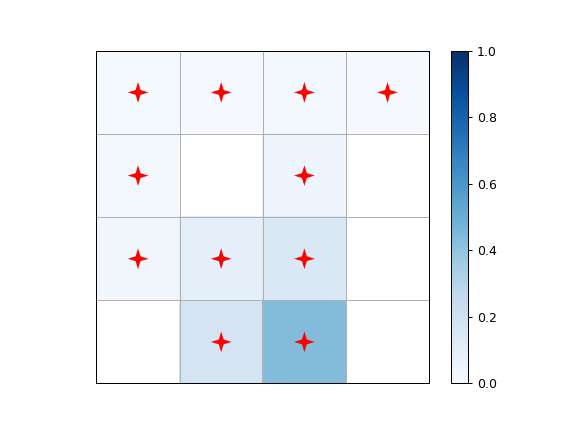

In [30]:
policy = UniformRandomPolicy(env)
Vs, Qsa = mdp.policy_evaluation(policy)
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(policy=policy, values=Vs)

In the stochastic case, the value-functions are also calculated applying the recursive Bellman expectation equation. As an illustration, this is done manually again for state 14. Qwest is the Q-value for "going west". In the stochastic case, there is only a 33.33% probability of getting in cell 13, as there is also a 33.33% probability of getting in cell 10, and a 33.33% probability of staying in cell 14. The same is true for the other 3 actions:

In [31]:
Ppolicy = 0.25
Paction = 1.0 / 3.0
R = 1.0

Qwest = Paction * (Vs[13].item() + Vs[14].item() + Vs[10].item())
Qsouth = Paction * (Vs[14].item() + Vs[13].item() + R)
Qeast = Paction * (R + Vs[14].item() + Vs[10].item())
Qnorth = Paction * (Vs[10].item() + Vs[13].item() + R)

print("Values for state 14:")
print("Qwest is " + str(Qwest))
print("Qsouth is " + str(Qsouth))
print("Qeast is " + str(Qeast))
print("Qnorth is " + str(Qnorth))
print("V is " + str(Ppolicy * (Qnorth + Qsouth + Qwest + Qeast)))

Values for state 14:
Qwest is 0.25238823631273627
Qsouth is 0.5383705157436001
Qeast is 0.5271147796473202
Qnorth is 0.43929117723455224
V is 0.43929117723455224


#### Policy Improvement 

The calculated state-value function V can be used to improve the policy:

[[0.7804878  0.65853659 0.53658537 0.53658537]
 [0.7804878  0.         0.41463415 0.        ]
 [0.7804878  0.7804878  0.70731707 0.        ]
 [0.         0.85365854 0.92682927 0.        ]]
[[0.7804878  0.7398374  0.7398374  0.7398374 ]
 [0.4796748  0.43902439 0.39837398 0.65853659]
 [0.53658537 0.53658537 0.49593496 0.57723577]
 [0.35772358 0.35772358 0.35772358 0.53658537]
 [0.7804878  0.5203252  0.5203252  0.5203252 ]
 [0.         0.         0.         0.        ]
 [0.41463415 0.23577236 0.41463415 0.17886179]
 [0.         0.         0.         0.        ]
 [0.5203252  0.5203252  0.5203252  0.7804878 ]
 [0.54471545 0.7804878  0.5203252  0.49593496]
 [0.70731707 0.56910569 0.44715447 0.39837398]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.54471545 0.59349593 0.85365854 0.56910569]
 [0.82926829 0.92682927 0.87804878 0.85365854]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


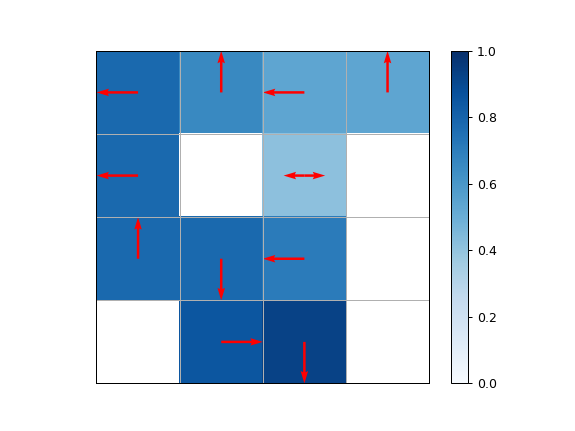

In [32]:
policy = mdp.policy_improvement(Vs)
Vs, Qsa = mdp.policy_evaluation(policy)
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(policy=policy, values=Vs)

It's time to create an agent who plays the game many times following this policy to see how many victories were achieved:

In [33]:
agent = Agent(env)
episodes = agent.run(policy, num_of_episodes=100)
print("number of wins: " + str(env.num_of_wins(episodes)))

number of wins: 69


Recall that the number of victories was very low following the uniform random policy. By improving the policy only one time, this number has already been increased enormously! But is this the optimal policy?

#### Policy Iteration 

First the optimal policy is calculated using the policy iteration method:

[[0.82352941 0.82352941 0.82352941 0.82352941]
 [0.82352941 0.         0.52941176 0.        ]
 [0.82352941 0.82352941 0.76470588 0.        ]
 [0.         0.88235294 0.94117647 0.        ]]
[[0.82352941 0.82352941 0.82352941 0.82352941]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.7254902  0.7254902  0.7254902  0.82352941]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.82352941 0.54901961 0.54901961 0.54901961]
 [0.         0.         0.         0.        ]
 [0.52941176 0.25490196 0.52941176 0.2745098 ]
 [0.         0.         0.         0.        ]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.56862745 0.82352941 0.54901961 0.52941176]
 [0.76470588 0.58823529 0.49019608 0.45098039]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.56862745 0.60784314 0.88235294 0.58823529]
 [0.8627451  0.94117647 0.90196078 0.88235294]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


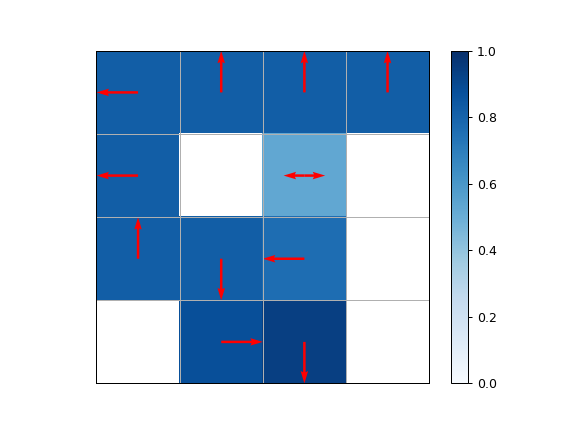

In [34]:
policy, Vs, Qsa = mdp.policy_iteration()
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(policy=policy, values=Vs)

The policy obtained after one policy improvement step was not the optimal one, but still very close. It is seen that the optimal policy choses actions that avoid falling into a hole.

The optimal value-functions are calculated using the Bellman optimality equations, e.g. for state 14: 

In [35]:
Paction = 1.0 / 3.0
R = 1.0

Qwest = Paction * (Vs[13].item() + Vs[14].item() + Vs[10].item())
Qsouth = Paction * (Vs[14].item() + Vs[13].item() + R)
Qeast = Paction * (R + Vs[14].item() + Vs[10].item())
Qnorth = Paction * (Vs[10].item() + Vs[13].item() + R)

print("Values for state 14:")
print("Qwest is " + str(Qwest))
print("Qsouth is " + str(Qsouth))
print("Qeast is " + str(Qeast))
print("Qnorth is " + str(Qnorth))
print("V is " + str(max([Qnorth, Qsouth, Qwest, Qeast])))

Values for state 14:
Qwest is 0.8627450980392144
Qsouth is 0.9411764705882346
Qeast is 0.9019607843137246
Qnorth is 0.8823529411764697
V is 0.9411764705882346


Note that in this case V is the maximum of all Q-values, and not the average weighted by the policy probabilities. The weighted mean was calculated in the case of policy evaluation.

#### Value Iteration 

The value iteration method also gives the optimal policy and the corresponding optimal value functions:

[[0.82352941 0.82352941 0.82352941 0.82352941]
 [0.82352941 0.         0.52941176 0.        ]
 [0.82352941 0.82352941 0.76470588 0.        ]
 [0.         0.88235294 0.94117647 0.        ]]
[[0.82352941 0.82352941 0.82352941 0.82352941]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.7254902  0.7254902  0.7254902  0.82352941]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.82352941 0.54901961 0.54901961 0.54901961]
 [0.         0.         0.         0.        ]
 [0.52941176 0.25490196 0.52941176 0.2745098 ]
 [0.         0.         0.         0.        ]
 [0.54901961 0.54901961 0.54901961 0.82352941]
 [0.56862745 0.82352941 0.54901961 0.52941176]
 [0.76470588 0.58823529 0.49019608 0.45098039]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.56862745 0.60784314 0.88235294 0.58823529]
 [0.8627451  0.94117647 0.90196078 0.88235294]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


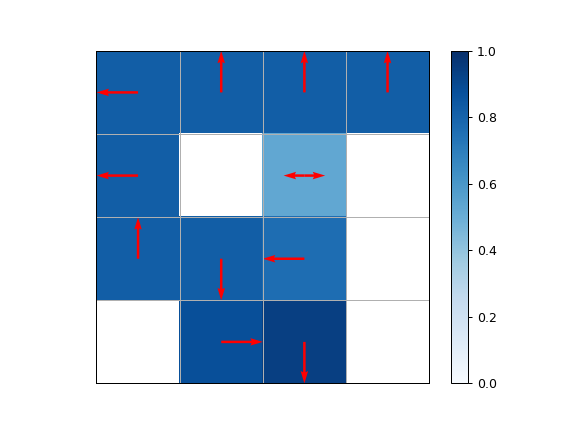

In [36]:
policy, Vs, Qsa = mdp.value_iteration()
print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(policy=policy, values=Vs)

Finally the agent plays the game 1000 times following the optimal policy. As the reward is 1 in case of winning, and 0 in all other cases, the optimal state-value function, which gives the expected return following the optimal policy, may be interpreted as the percentage of wins from a given state. Starting in state 0, the expected number of wins is 82% because its state-value is 0.82. However, this percentage doesn't take into account the maximum number of steps equal to 100. Consequently, the expected number of wins will be a bit lower:

In [37]:
episodes = agent.run(policy, num_of_episodes=1000)
print("number of wins: " + str(env.num_of_wins(episodes)))

number of wins: 737


Playing 1000 games in an environment without time limit should give more victories, and the number of victories should be around 820:

In [38]:
env = FrozenLake.make(time_limit=False)
agent = Agent(env)
episodes = agent.run(policy, num_of_episodes=1000)
print("number of wins: " + str(env.num_of_wins(episodes)))

number of wins: 814


#### Conclusion 

Althought value iteration and policy iteration are iterative procedures that approximate the exact solution, their solution will be very close to it, as the exact MDP was used to obtain it. When the MDP is not known, however, a learning agent is needed who will build the MDP explicitly or implicitly by trial-and error. The solutions obtained by this learning agent will be less accurate.

## Discount Factor 

A Markov Decision Process is determined by the set of states, the set of actions, the state transition probabitility matrix and the reward matrix. The MDP requires an aditional element to be fully defined, a parameter called the discount factor, denoted by the greek letter gamma. 

Reinforcement learning is all about finding an optimal behaviour in order to gain maximum total reward. The discount factor is a value between 0.0 and 1.0 and it determines how much weight future rewards are given when calculating this total reward, which is called the return. If the discount factor is equal to 0.0, only the immediate reward is considered, whereas it is equal to 1.0, the future rewards are fully taken into account. If the discount factor is greater than 0.0 and smaller than 1.0, then the future rewards are discounted.

A simple example is given to illustrate the impact of the discount factor on the calculated return. Suppose there are 100 subsequent states and each state transition is rewarded with -1, which is a common practice when the shortest path must be found. The total reward or return G is calculated as:

G = R[0] + gamma x R[1] + gamma² x R[2] + ...

where gamma is the discount factor and R[i] is the i-th reward equal to -1. Now the return is calculated for different values of gamma:

In [39]:
rewards = -np.ones(100)
discount_factors = np.linspace(0.0, 1.0, 11)

G = []
n = np.arange(0, len(rewards))
for gamma in discount_factors:
    G.append(np.sum(rewards * (gamma**n)))

print("discount factor | return")
print(np.hstack((discount_factors[:, np.newaxis], np.array(G)[:, np.newaxis])))

discount factor | return
[[   0.           -1.        ]
 [   0.1          -1.11111111]
 [   0.2          -1.25      ]
 [   0.3          -1.42857143]
 [   0.4          -1.66666667]
 [   0.5          -2.        ]
 [   0.6          -2.5       ]
 [   0.7          -3.33333333]
 [   0.8          -5.        ]
 [   0.9          -9.99973439]
 [   1.         -100.        ]]


When the disount factor is 0.0, return G is equal to -1, which is the immediate reward, and when the discount factor is 1.0, return G is equal to -100, which is the undiscounted sum of all rewards. The larger the discount factor, the larger the return, as the future rewards are less discounted when the discount factor approaches 1.0.

The choice of the discount factor depends on the problem to solve. If the MDP is not episodic, meaning that there are no terminal states, then a value of 1.0 is not allowed, as this would make the returns infinitely large. In this case, it is common to set the discount factor to 0.9. In case of episodic MDPs, the discount factor may be set to 1.0, although a smaller value could make the system converge more easily. In all of the above examples, a discount factor equal to 1.0 was applied, because this is the default value in class MarkovDecisionProcess. For Frozen Lake, a discount factor of 1.0 could be considered even the most interesting choice, because the state-value function gives the expected percentage of wins in this case. However, if the shortest path must be found, a discount factor smaller than 1.0 may be a better choice. To get a better understanding of the meaning of the discount factor, some Frozen Lake solutions are presented here in which a different discount factor was used.

### Deterministic case

First the optimal policy and value functions are recalculated for the deterministic case using a discount factor of 0.0 and 0.9. When the discount factor is 0.0, the optimal state-value function gives the maximum immediate reward that can be obtained in each state. Therefore all cells have a state-value of 0.0, unless cell 14 next to to the final cell, which has a state-value of 1.0. Because the return only accounts for the immediate reward, the optimal policy doesn't look further than the adjacent cells, and therefore the uniform random policy is not improved, unless in cell 14:

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]


<IPython.core.display.Javascript object>


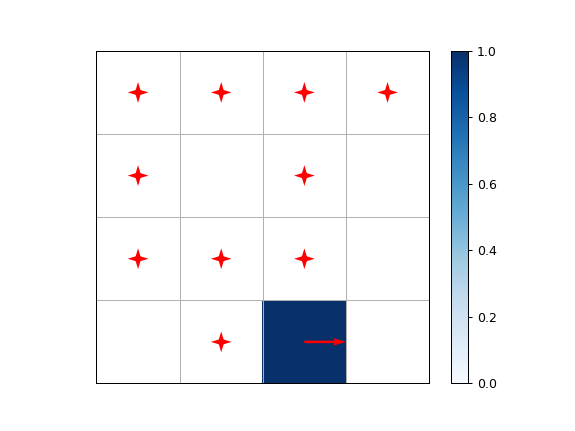

In [40]:
env = FrozenLake.make(is_slippery=False)
mdp = GymMDP(env, gamma=0.0)

policy, Vs, Qsa = mdp.value_iteration()

print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(values=Vs, policy=policy)

Applying a discount factor equal to 0.9 gives an optimal policy that corresponds to the shortest path. This makes sense as the discount on the final reward becomes larger the more steps it took to get at the final state. In other words, less steps leads to a larger return:

[[0.59049 0.6561  0.729   0.6561 ]
 [0.6561  0.      0.81    0.     ]
 [0.729   0.81    0.9     0.     ]
 [0.      0.9     1.      0.     ]]
[[0.531441 0.59049  0.59049  0.531441]
 [0.531441 0.       0.6561   0.59049 ]
 [0.59049  0.729    0.59049  0.6561  ]
 [0.6561   0.       0.59049  0.59049 ]
 [0.59049  0.6561   0.       0.531441]
 [0.       0.       0.       0.      ]
 [0.       0.81     0.       0.6561  ]
 [0.       0.       0.       0.      ]
 [0.6561   0.       0.729    0.59049 ]
 [0.6561   0.81     0.81     0.      ]
 [0.729    0.9      0.       0.729   ]
 [0.       0.       0.       0.      ]
 [0.       0.       0.       0.      ]
 [0.       0.81     0.9      0.729   ]
 [0.81     0.9      1.       0.81    ]
 [0.       0.       0.       0.      ]]


<IPython.core.display.Javascript object>


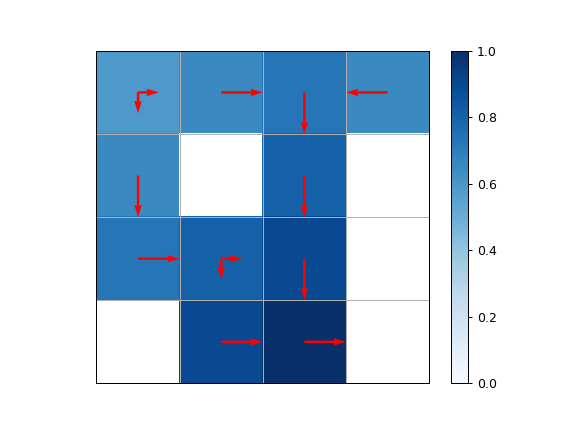

In [41]:
mdp = GymMDP(env, gamma=0.9)

policy, Vs, Qsa = mdp.value_iteration()

print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(values=Vs, policy=policy)

In fact, all discounted MDPs lead to the same optimal policy showing the shortest path.

### Stochastic case 

The simulations are repeated for the stochastic Frozen Lake environment. Again, a discount factor of 0.0 and 0.9 is used. When the discount factor is 0.0, the optimal state-value function is the expected immediate reward. Therefore all cells have a state-value of 0.0, unless cell 14, which has a state-value of 0.3333 because there is only a 33.33% probability of receiving a reward of 1.0 by getting in cell 15. The optimal policy is a uniform random policy, except for cell 14, where there are 3 possible actions instead of 4:

[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.33333333 0.        ]]
[[0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


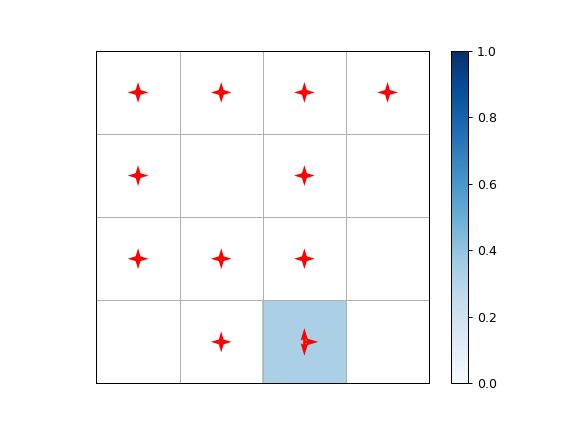

In [42]:
env = FrozenLake.make(is_slippery=True)
mdp = GymMDP(env, gamma=0.0)

policy, Vs, Qsa = mdp.value_iteration()

print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(values=Vs, policy=policy)

When the discount factor is 0.9, the optimal policy is very close to the optimal policy determined earlier applying a discount factor of 1.0. Only cell 2 shows another optimal action:

[[0.0688909  0.06141457 0.07440976 0.05580732]
 [0.09185454 0.         0.11220821 0.        ]
 [0.14543635 0.24749695 0.29961759 0.        ]
 [0.         0.3799359  0.63902015 0.        ]]
[[0.0688909  0.066648   0.066648   0.05975891]
 [0.03909164 0.0429902  0.0407473  0.06141457]
 [0.07440976 0.06882903 0.07272759 0.0574895 ]
 [0.03906513 0.03906513 0.03348439 0.05580732]
 [0.09185454 0.07118727 0.06429818 0.04822363]
 [0.         0.         0.         0.        ]
 [0.11220821 0.08988528 0.11220821 0.02232293]
 [0.         0.         0.         0.        ]
 [0.07118727 0.11787999 0.10180545 0.14543635]
 [0.15761168 0.24749695 0.20386605 0.13351618]
 [0.29961759 0.26595513 0.22536851 0.10791155]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.18822986 0.30568681 0.3799359  0.26595513]
 [0.39557209 0.63902015 0.61492466 0.53719938]
 [0.         0.         0.         0.        ]]


<IPython.core.display.Javascript object>


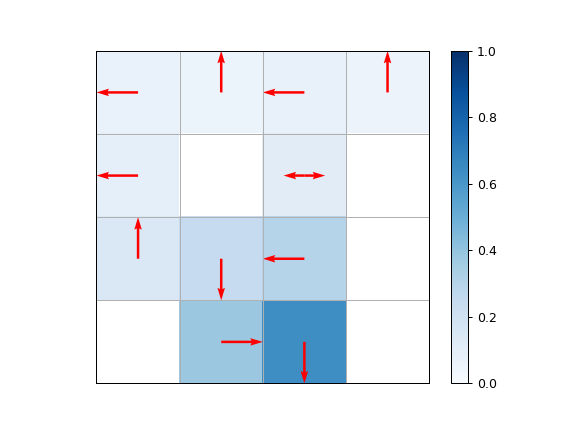

In [43]:
mdp = GymMDP(env, gamma=0.9)

policy, Vs, Qsa = mdp.value_iteration()

print(np.reshape(Vs, (4, 4), order="c"))
print(Qsa)
env.plot(values=Vs, policy=policy)